In [1]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746507 sha256=a1a05c7b758a9a7ca4fbf871c2cae03512616ae04848fa1fe0cd4659d4e4a057
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [2]:
import cupy as cp
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20

# 1. An explanation is given of what is the difference between cupy and numpy. How does cupy handle data transfers between CPU and GPU?





## Difference between cupy and numpy

+ CuPy is based on NVIDIA's CUDA platform, which utilizes the GPU's parallel processing capabilities for accelerated numerical computations, so CuPy is significantly faster for computationally intensive tasks, especially those involving large arrays. CuPy also effectively manages memory allocation and deallocation on both the CPU and GPU. It utilizes a unified memory model, allowing for efficient data sharing between the CPU and GPU without explicit memory copies.

+ NumPy, on the other hand, operates solely on the CPU's memory and processing units and, while relatively performant, is limited by the CPU's single-threaded operations. Besides, NumPy handles memory management independently for the CPU and GPU, requiring explicit memory transfers between the two.

## How does cupy handles data transfers between CPU and GPU?

+ Cupy uses memory pool for memory allocations by default. The memory pool significantly improves the performance by mitigating the overhead of memory allocation and CPU/GPU synchronization. During CPU-to-GPU data transfer, pinned memory pool (non-swappable CPU memory) is used.

+ Host-to-Device Transfers: can be done by cupy.asarray()

In [ ]:
x_cpu = np.array([2, 0, 2, 3])
x_gpu = cp.asarray(x_cpu)  # move the array to the current device by cupy.asarray()

+ Device-to-Host Transfers: can be done by cupy.asnumpy() or cupy.ndarray.get()

In [ ]:
x_gpu = cp.array([2, 0, 2, 4])
x_cpu = cp.asnumpy(x_gpu)  # move the array to the host by cupy.asnumpy()
x_cpu = x_gpu.get() # or by cupy.ndarray.get()

# 2. Function saxpy that runs on GPU using cupy is provided.

In [ ]:
@cp.fuse()
def cp_saxpy(x, y, a):
    return x*a + y

In [ ]:
%%timeit
cp_saxpy(cp.random.rand(1000, 1000).astype(cp.float32), cp.random.rand(1000, 1000).astype(cp.float32), cp.float32(2.0))

402 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 3.  Graph (OX - size of arrays, OY - computation time) is given. Plot computation time of numpy and cupy implementations of saxpy.

In [ ]:
def np_saxpy(x, y, a):
    return x*a + y

In [ ]:
np_results = []
for size in np.logspace(1, 4, 20):
    size = int(size)
    np_x = np.random.rand(size, size).astype(np.float32)
    np_y = np.random.rand(size, size).astype(np.float32)
    np_a = np.float32(5.0)
    t = %timeit -o -q np_saxpy(np_x, np_y, np_a)
    np_results.append(t.best)

In [ ]:
cp_results = []
for size in cp.logspace(1, 4, 20):
    size = int(size)
    cp_x = cp.random.rand(size, size).astype(cp.float32)
    cp_y = cp.random.rand(size, size).astype(cp.float32)
    cp_a = cp.float32(5.0)
    t = %timeit -o -q cp_saxpy(cp_x, cp_y, cp_a)
    cp_results.append(t.best)

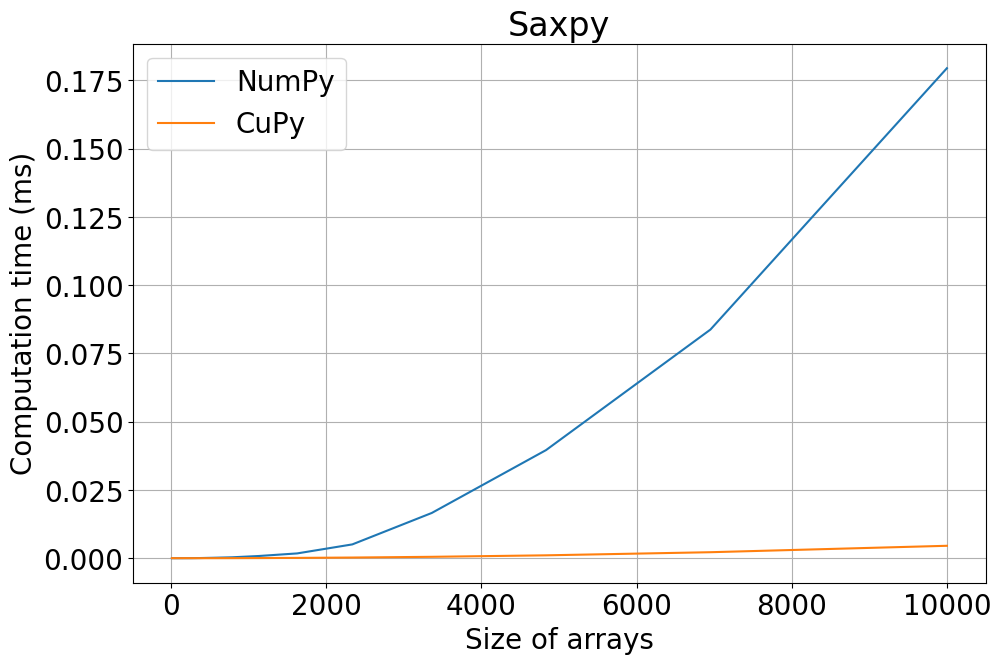

In [ ]:
plt.plot(np.logspace(1, 4, 20), np_results, label='NumPy')
plt.plot(np.logspace(1, 4, 20), cp_results, label='CuPy')
plt.title('Saxpy')
plt.xlabel('Size of arrays')
plt.ylabel('Computation time (ms)')
plt.legend()
plt.grid()
plt.show()

# 4. Bifurcation map is performed using cupy arrays.

Text(0, 0.5, '$x_{\\infty}$')

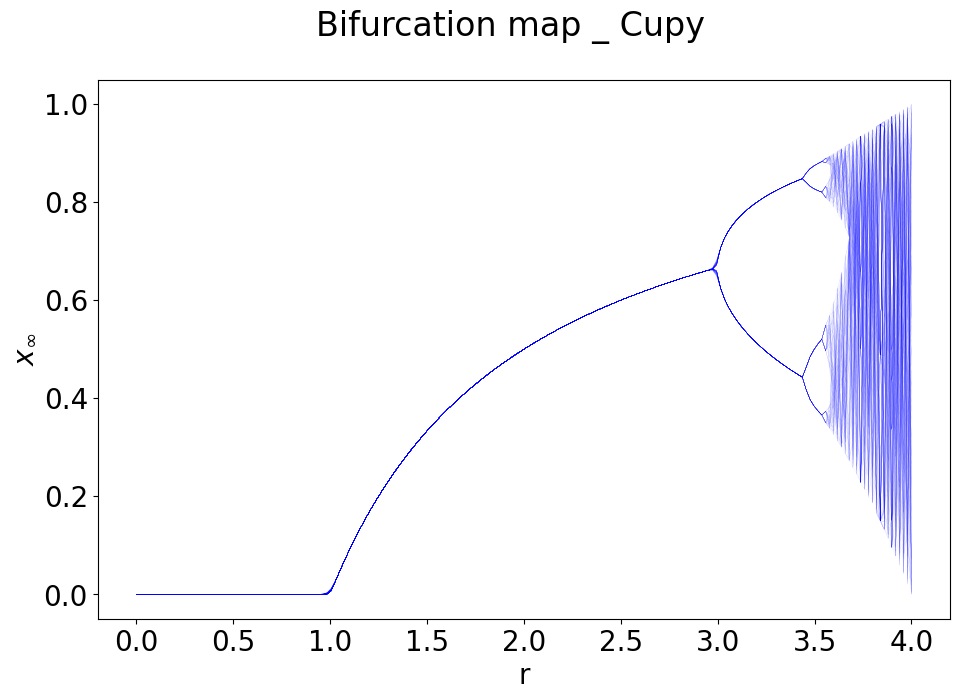

In [ ]:
def bif_map_cp(x_0, r, n=200):
    x = cp.array([x_0])
    for _ in cp.arange(n - 1):
        x_1 = r * x[-1] * (1 - x[-1])
        x = cp.append(x, x_1)
    return x

def bifurcation_cp(x_0, r, m=0, n=200):
    assert isinstance(r, (cp.ndarray))
    assert m <= n

    arr_dict = bif_map_cp(x_0, r[0], n)[-int(m):]
    for r_i in r[1:]:
        x_ri = bif_map_cp(x_0, r_i, n)
        arr_dict = cp.vstack([arr_dict, x_ri[-int(m):]])

    arr_dict = cp.append(r.reshape(-1, 1), arr_dict, axis=1)
    return arr_dict

m = 200
arr_dict = bifurcation_cp(cp.random.rand(), cp.linspace(0, 4, 200), 200, 300)
arr_dict = cp.asnumpy(arr_dict)
plt.plot([[key] * m for key in arr_dict[:, 0]], arr_dict[:, 1:], 'b', lw=.02)
plt.suptitle('Bifurcation map _ Cupy')
plt.xlabel('r')
plt.ylabel('$x_{\infty}$')

#5. Graph (OX - number of rs, OY - computation time) is given. Plot computation time of CPU, CPU parallel, and GPU implementations.

### CPU

Text(0, 0.5, '$x_{\\infty}$')

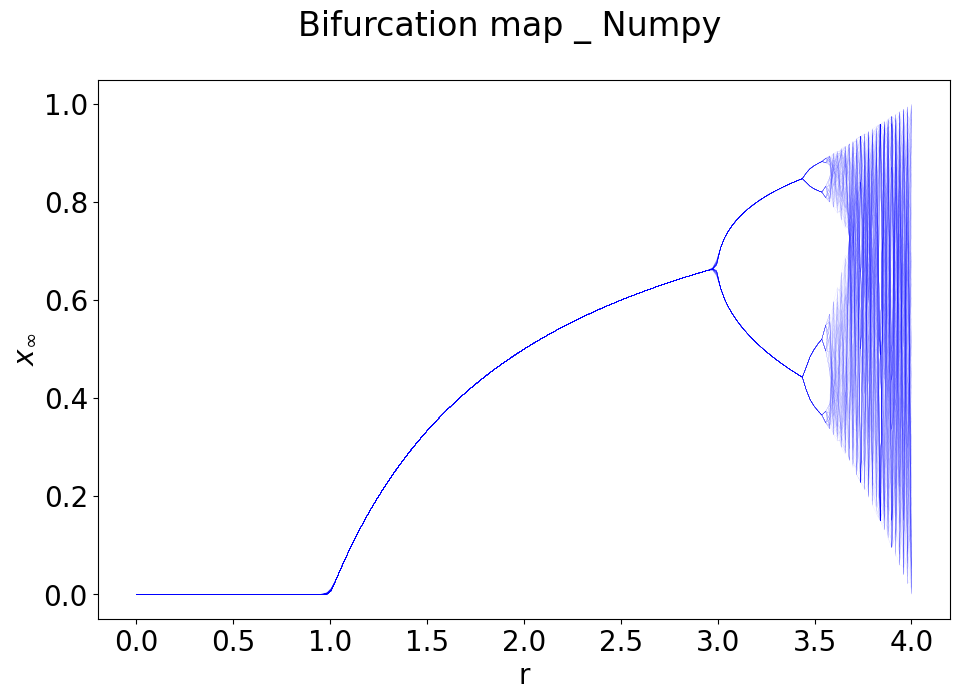

In [ ]:
def bif_map_np(x_0, r, n=200):
    x = np.array([x_0])
    for _ in np.arange(n - 1):
        x_1 = r * x[-1] * (1 - x[-1])
        x = np.append(x, x_1)
    return x

def bifurcation_np(x_0, r, m=0, n=200):
    assert isinstance(r, (np.ndarray))
    assert m <= n

    arr_dict = bif_map_np(x_0, r[0], n)[-int(m):]
    for r_i in r[1:]:
        x_ri = bif_map_np(x_0, r_i, n)
        arr_dict = np.vstack([arr_dict, x_ri[-int(m):]])

    arr_dict = np.append(r.reshape(-1, 1), arr_dict, axis=1)
    return arr_dict

m = 200
arr_np = bifurcation_np(np.random.rand(), np.linspace(0, 4, 200), 200, 300)
plt.plot([[key] * m for key in arr_np[:, 0]], arr_np[:, 1:], 'b', lw=.02)
plt.suptitle('Bifurcation map _ Numpy')
plt.xlabel('r')
plt.ylabel('$x_{\infty}$')

### CPU Parallel

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%writefile bifurcation.py
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

def bif_map_np(x_0, r, n=200):
    x = np.array([x_0])
    for _ in np.arange(n - 1):
        x_1 = r * x[-1] * (1 - x[-1])
        x = np.append(x, x_1)
    return x

def bifurcation_np(x_0, r, m=0, n=200):
    assert isinstance(r, (np.ndarray))
    assert m <= n

    arr_dict = bif_map_np(x_0, r[0], n)[-int(m):]
    for r_i in r[1:]:
        x_ri = bif_map_np(x_0, r_i, n)
        arr_dict = np.vstack([arr_dict, x_ri[-int(m):]])

    arr_dict = np.append(r.reshape(-1, 1), arr_dict, axis=1)
    return arr_dict

comm = MPI.COMM_WORLD

start = MPI.Wtime()
size = comm.Get_size()
rank = comm.Get_rank()

m = 200
n = 300 if len(sys.argv) == 1 else int(sys.argv[1])
x0 = np.random.rand()

r_space = np.linspace(0, 4, 200)
r_per_rank = np.split(r_space, size)
r_subspace = r_per_rank[rank]

arr_rank = bifurcation_np(x0, r_subspace, m, n)
result_arr = comm.gather(arr_rank, root=0)
end = MPI.Wtime()

if rank == 0:
    result_arr = np.concatenate(result_arr, 0)
    with open(f'time-{n}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Overwriting bifurcation.py


In [ ]:
!mpirun --allow-run-as-root -n 1 python3 bifurcation.py
print('MPI done')

MPI done


In [ ]:
n_arr = [300, 500, 800, 1000, 1200, 1500]
n_processes = 2

for n in n_arr:
    !mpirun --oversubscribe --allow-run-as-root -n {n_processes} python3 bifurcation.py {n}

### Plot

In [ ]:
n_arr = [300, 500, 800, 1000, 1200, 1500]
mpi_time = []

for n in n_arr:
    with open(f'time-{n}.pkl', 'rb') as f:
        time = pickle.load(f)
    mpi_time.append(time)

In [ ]:
np_time = []
cp_time = []

for n in n_arr:
  t_np = %timeit -o -q bifurcation_np(np.random.rand(), np.linspace(0, 4, 200), 200, n)
  np_time.append(t_np.best)
  t_cp = %timeit -o -q bifurcation_cp(cp.random.rand(), cp.linspace(0, 4, 200), 200, n)
  cp_time.append(t_cp.best)

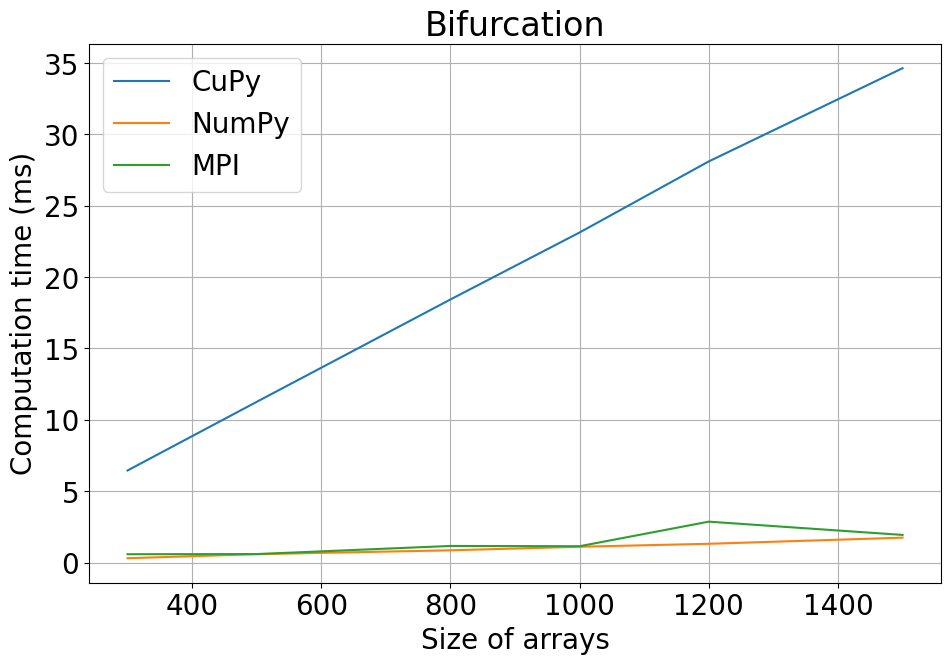

In [ ]:
plt.plot(n_arr, cp_time, label='CuPy')
plt.plot(n_arr, np_time, label='NumPy')
plt.plot(n_arr, mpi_time, label='MPI')
plt.title('Bifurcation')
plt.xlabel('Size of arrays')
plt.ylabel('Computation time (ms)')
plt.legend()
plt.grid()
plt.show()